<a href="https://colab.research.google.com/github/vittoriadepaula/r4ds/blob/master/NVL_035.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import json

pd.options.display.float_format = '{:,.2f}'.format

In [ ]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.models import HoverTool

In [14]:
#df = pd.read_csv('/Users/user/Downloads/dados.csv')

from google.colab import files  
uploaded = files.upload()

Saving data.csv to data.csv


In [27]:
df = pd.read_csv("/content/data.csv", encoding= 'unicode_escape') 




       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

            InvoiceDate  UnitPrice  CustomerID         Country  
0        1

In [34]:

df.head()



,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,"17,850.00",United Kingdom


In [49]:
today = datetime.strptime('2011-12-11', '%Y-%m-%d')

df['invoicedate'] = df['invoicedate'].astype('datetime64[ms]')
df.dtypes

agg_dict1 = {
    'stockcode': 'count',
    'invoicedate': 'max',
    'unitprice': 'sum'
}
df_rfm = df.groupby('customerid').agg(agg_dict1).reset_index()
df_rfm.columns = ['customerid', 'frequency', 'max_date', 'monetary']
df_rfm['recency'] = (today - df_rfm['max_date']).dt.days
df_rfm.drop(['max_date'], axis=1, inplace=True)

In [51]:
r_labels, f_labels, m_labels = range(5, 0, -1), range(1,6), range(1,6)

df_rfm['r_score'] = pd.qcut(df_rfm['recency'], q=5, labels=r_labels).astype(int)
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'], q=5, labels=f_labels).astype(int)
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], q=5, labels=m_labels).astype(int)

df_rfm['rfm_sum'] = df_rfm['r_score'] + df_rfm['f_score'] + df_rfm['m_score']

In [52]:
def assign_label(df, r_rule, fm_rule, label, colname='rfm_label'):
    df.loc[(df['r_score'].between(r_rule[0], r_rule[1]))
            & (df['f_score'].between(fm_rule[0], fm_rule[1])), colname] = label
    return df

In [56]:
df_rfm['rfm_label'] = ''

df_rfm = assign_label(df_rfm, (5,5), (4,5), 'champions')
df_rfm = assign_label(df_rfm, (3,4), (4,5), 'loyal customers')
df_rfm = assign_label(df_rfm, (4,5), (2,3), 'potential loyalist')
df_rfm = assign_label(df_rfm, (5,5), (1,1), 'new customers')
df_rfm = assign_label(df_rfm, (4,4), (1,1), 'promising')
df_rfm = assign_label(df_rfm, (3,3), (3,3), 'needing attention')
df_rfm = assign_label(df_rfm, (3,3), (1,2), 'about to sleep')
df_rfm = assign_label(df_rfm, (1,2), (3,4), 'at risk')
df_rfm = assign_label(df_rfm, (1,2), (5,5), 'cant loose them')
df_rfm = assign_label(df_rfm, (1,2), (1,2), 'hibernating')

df.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,"17,850.00",United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,"17,850.00",United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,"17,850.00",United Kingdom


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


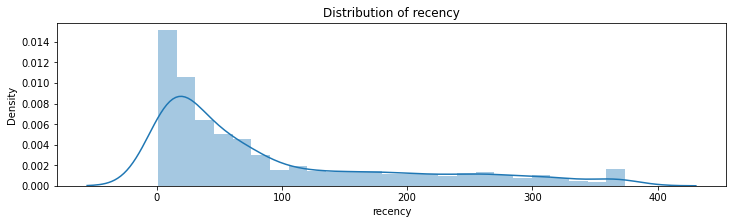

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


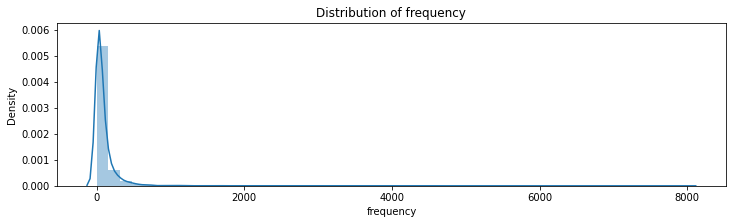

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


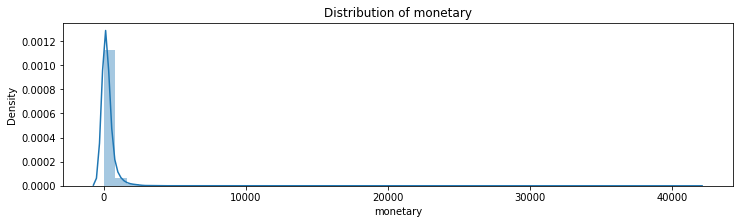

In [57]:
colnames = ['recency', 'frequency', 'monetary']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    sns.distplot(df_rfm[col])
    ax.set_title('Distribution of %s' % col)
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

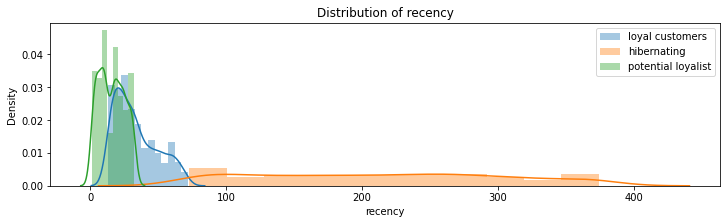

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

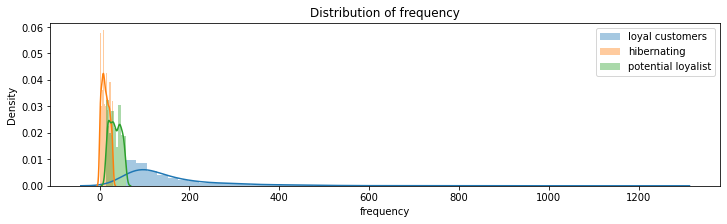

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

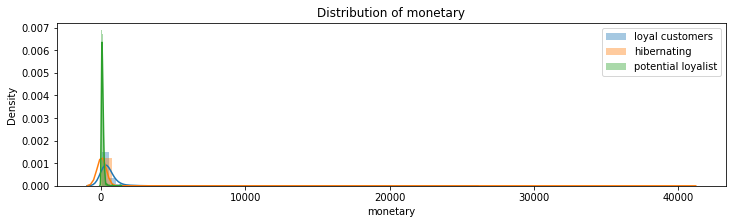

In [58]:
segments = ['loyal customers', 'hibernating', 'potential loyalist']

for col in colnames:
    fig, ax = plt.subplots(figsize=(12,3))
    for segment in segments:
        sns.distplot(df_rfm[df_rfm['rfm_label']==segment][col], label=segment)
    ax.set_title('Distribution of %s' % col)
    plt.legend()
    plt.show()

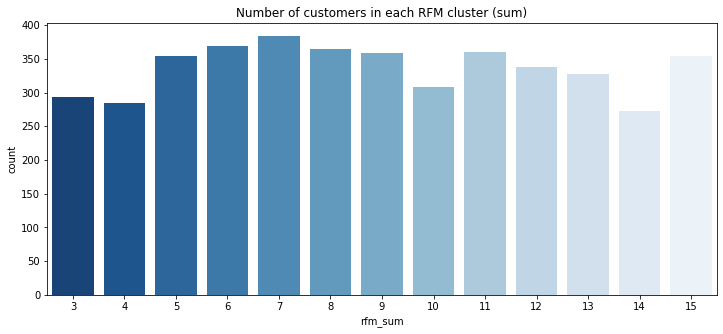

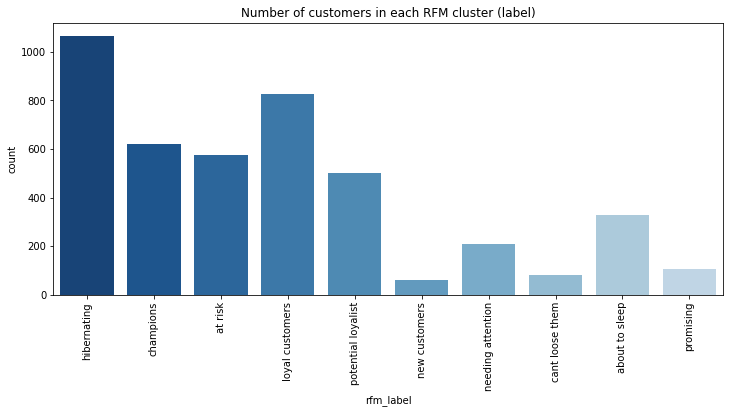

In [59]:
palette = sns.color_palette("Blues_r", n_colors=13)

for rfm_type in ['sum', 'label']:
    fig, ax = plt.subplots(figsize=(12,5))
    sns.countplot(x='rfm_'+rfm_type, data=df_rfm, palette=palette)
    ax.set_title('Number of customers in each RFM cluster (%s)' % rfm_type)
    if rfm_type == 'label':
        plt.xticks(rotation=90)
    plt.show()

In [63]:
agg_dict2 = {
    'customerid': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': 'sum'
}

df_analysis = df_rfm.groupby('rfm_label').agg(agg_dict2).sort_values(by='recency').reset_index()
df_analysis.rename({'rfm_label': 'label', 'customerid': 'count'}, axis=1, inplace=True)
df_analysis['count_share'] = df_analysis['count'] / df_analysis['count'].sum()
df_analysis['monetary_share'] = df_analysis['monetary'] / df_analysis['monetary'].sum()
df_analysis['monetary'] = df_analysis['monetary'] / df_analysis['count']

df_analysis.head()

,label,count,recency,frequency,monetary,count_share,monetary_share
0,champions,620,5.94,287.09,929.92,0.14,0.41
1,new customers,60,7.38,7.73,29.94,0.01,0.00
2,potential loyalist,502,15.90,35.08,118.95,0.11,0.04
3,promising,105,23.01,7.62,30.57,0.02,0.00
4,loyal customers,825,33.31,162.30,546.90,0.19,0.32


In [78]:
!pip install squarify
import squarify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


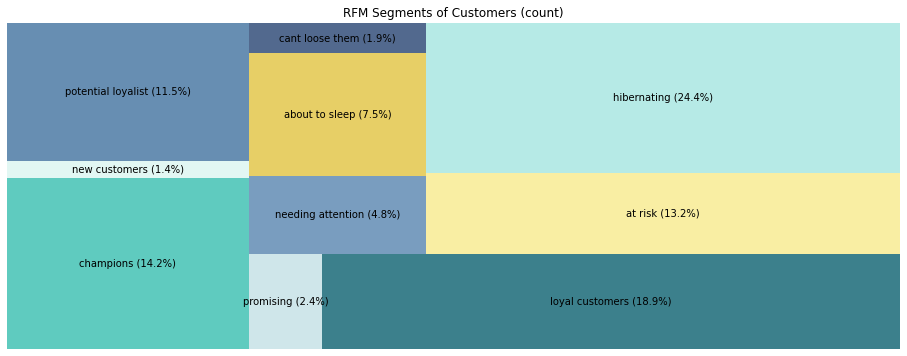

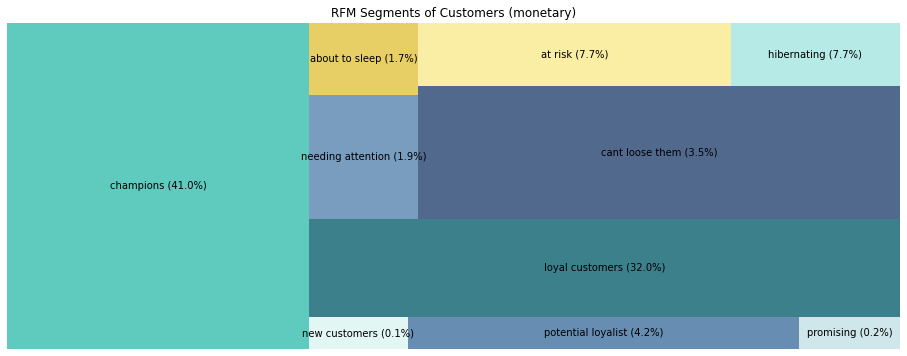

In [79]:
colors = ['#37BEB0', '#DBF5F0', '#41729F', '#C3E0E5', '#0C6170', '#5885AF', '#E1C340', '#274472', '#F8EA8C', '#A4E5E0', '#1848A0']

import squarify 
for col in ['count', 'monetary']:
    labels = df_analysis['label'] + df_analysis[col + '_share'].apply(lambda x: ' ({0:.1f}%)'.format(x*100))

    fig, ax = plt.subplots(figsize=(16,6))
    squarify.plot(sizes=df_analysis[col], label=labels, alpha=.8, color=colors)
    ax.set_title('RFM Segments of Customers (%s)' % col)
    plt.axis('off')
    plt.show()

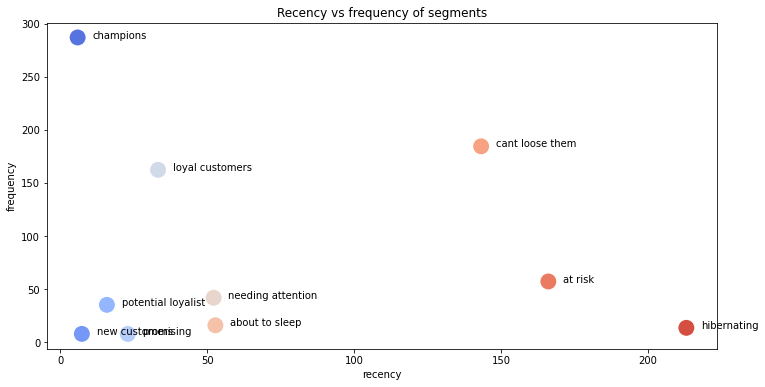

In [80]:
palette = sns.color_palette("coolwarm", 10)

fig, ax = plt.subplots(figsize=(12,6))
plot = sns.scatterplot(x='recency', y='frequency', data=df_analysis, hue='label', s=300, palette=palette)

for i in range(len(df_analysis)):
     plot.text(df_analysis['recency'][i]+5,
               df_analysis['frequency'][i]-0.5,
               df_analysis['label'][i],
               horizontalalignment='left',
               size='medium', color='black')

ax.set_title('Recency vs frequency of segments')
ax.get_legend().remove()
plt.show()